In [2]:
# standard library packages
import getpass
import json
import os
import pathlib
import subprocess
from glob import glob
from io import BytesIO
from shapely.geometry import Point

# other necessary packages
import earthpy.appeears as eaapp
import folium
import geopandas as gpd
import hvplot.pandas
import hvplot.xarray
import pandas as pd
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import requests
import rioxarray as rxr
import xarray as xr

In [20]:
weather_data = os.path.join(pathlib.Path.home(), 'Grizzly_Creek_Weather_data')

In [10]:
# Download the area boundary
# Must be attr_incident NOT polygon_incident. This may save much time...-.-
bounds_url= (
    'https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/'
    'WFIGS_Interagency_Perimeters/FeatureServer/0/'
    'query?where=attr_IncidentName%20%3D%20%27GRIZZLY%20CREEK%27&'
    'outFields=*&outSR=4326&f=json')

bounds_gdf= gpd.read_file(bounds_url)
  #this transforms the link to a geodataframe


/opt/conda/lib/python3.11/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/opt/conda/lib/python3.11/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/opt/conda/lib/python3.11/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/opt/conda/lib/python3.11/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime withou

In [11]:
bounds_gdf

,OBJECTID,poly_SourceOID,poly_IncidentName,poly_FeatureCategory,poly_MapMethod,poly_GISAcres,poly_CreateDate,poly_DateCurrent,poly_PolygonDateTime,poly_IRWINID,...,attr_Source,attr_IsCpxChild,attr_CpxName,attr_CpxID,attr_SourceGlobalID,GlobalID,Shape__Area,Shape__Length,attr_IncidentComplexityLevel,geometry
0,11275,13459,Grizzly Creek,Wildfire Final Fire Perimeter,GPS-Walked,322.00,NaT,2023-03-14 15:13:42.810000+00:00,2020-09-05 03:13:00+00:00,{3478A04D-5A7E-4E89-9342-80DE610BA9B3},...,FODR,None,None,None,{6668D67B-68EE-4CF8-AC3E-EAAD67743DA1},d5a38ca3-2c28-45eb-b06c-ca4394ecd056,0.000143,0.079356,None,"POLYGON ((-122.40703 42.27382, -122.40700 42.2..."
1,14453,13272,Grizzly Creek,Wildfire Final Fire Perimeter,Infrared Image,32431.62,NaT,2023-03-14 15:13:42.810000+00:00,2020-09-04 00:37:00+00:00,{BC150C8C-D9C8-4C14-8725-2B84D7695302},...,FODR,None,None,None,{E4E21DCE-C8EE-4133-B9F7-5CA2E5FBF79C},c9133643-c537-4030-a059-04d80c6c3a96,0.013763,1.346520,None,"MULTIPOLYGON (((-107.19151 39.66880, -107.1914..."


In [12]:
# in this cell we pick the incident we want for our boundary
# gdfs start at 0, the .loc[[#]] chooses the incident, or object, # from the list. In this case, we wanted incident 1
# this resest bounds_gdf to be only the selected object choosen via .loc[[]]
gcfire_bounds_gdf = bounds_gdf.loc[[1]]
gcfire_bounds_gdf

,OBJECTID,poly_SourceOID,poly_IncidentName,poly_FeatureCategory,poly_MapMethod,poly_GISAcres,poly_CreateDate,poly_DateCurrent,poly_PolygonDateTime,poly_IRWINID,...,attr_Source,attr_IsCpxChild,attr_CpxName,attr_CpxID,attr_SourceGlobalID,GlobalID,Shape__Area,Shape__Length,attr_IncidentComplexityLevel,geometry
1,14453,13272,Grizzly Creek,Wildfire Final Fire Perimeter,Infrared Image,32431.62,NaT,2023-03-14 15:13:42.810000+00:00,2020-09-04 00:37:00+00:00,{BC150C8C-D9C8-4C14-8725-2B84D7695302},...,FODR,None,None,None,{E4E21DCE-C8EE-4133-B9F7-5CA2E5FBF79C},c9133643-c537-4030-a059-04d80c6c3a96,0.013763,1.34652,None,"MULTIPOLYGON (((-107.19151 39.66880, -107.1914..."


<Axes: >

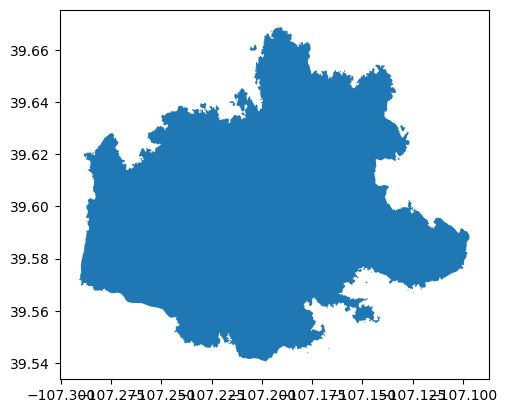

In [15]:
#plot final fire boundary
gcfire_bounds_gdf.plot()

In [29]:
#convert fire bounds to geojson
gcfire_bounds_gdf.to_file('gcfire_boundaries.geojson', driver='GeoJSON')

In [99]:
# link for max temperature data for garfield county, CO
max_temp_url = ('https://www.ncei.noaa.gov/access/monitoring/'
'climate-at-a-glance/county/time-series/CO-045/tmax/1/0/2019-2021.csv')

In [100]:
# read csv link and convert to df
garfield_cty_df = pd.read_csv(max_temp_url, header = 3, names = ['Date', 'Value'])
garfield_cty_df

,Date,Value
0,201901,33.4
1,201902,33.7
2,201903,43.0
3,201904,54.9
4,201905,56.1
5,201906,69.8
6,201907,80.0
7,201908,80.5
8,201909,72.3
9,201910,51.4


In [101]:
# adjust the years from ncei to normal years
garfield_cty_df['Date'] = pd.to_datetime(garfield_cty_df.Date, format = '%Y%m')
garfield_cty_df

,Date,Value
0,2019-01-01,33.4
1,2019-02-01,33.7
2,2019-03-01,43.0
3,2019-04-01,54.9
4,2019-05-01,56.1
5,2019-06-01,69.8
6,2019-07-01,80.0
7,2019-08-01,80.5
8,2019-09-01,72.3
9,2019-10-01,51.4


<Axes: title={'center': 'Mean Maximum Monthly Temperature for Garfield County, CO'}, xlabel='Year', ylabel='Temperature ($^\\circ$C)'>

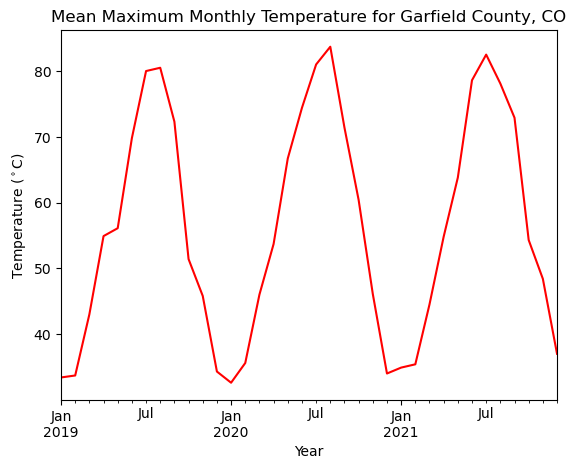

In [102]:
#plot max temp data
garfield_cty_df.plot(x='Date', y='Value', legend=False, xlabel='Year', 
                    ylabel= 'Temperature ($^\circ$C)', 
                    title= 'Mean Maximum Monthly Temperature for Garfield County, CO',
                    color= 'red')